In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="ticks", rc={'figure.figsize':(9,8)})
sns.set_context(rc = {"font.size":15, "axes.labelsize":15}, font_scale=2)
sns.set_palette('colorblind');
from pandas.api.types import CategoricalDtype

from scipy import stats

from scipy.stats import pearsonr,spearmanr, boxcox_normmax, chi2_contingency, chi2, f, shapiro, probplot
from scipy.special import boxcox1p

import statsmodels.api as sm
from statsmodels.formula.api import ols 

# pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

import warnings
warnings.filterwarnings('ignore')

from time import time

## Loading Dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Training data shape: ", train.shape)
print("Testing data shape: ", test.shape)

Training data shape:  (1460, 81)
Testing data shape:  (1459, 80)


## Removing outliers

In [3]:
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace = True)
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace = True)
train.reset_index(drop=True, inplace=True)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.shape

(1457, 81)

In [5]:
sale_price_df = train[['SalePrice']].copy()

### rbinding train and test data

In [6]:
data = pd.concat([train.drop(columns='SalePrice'), test], axis = 0)
data.shape

(2916, 80)

### checking for presence of null

In [7]:
round((data.isnull().sum()[data.isnull().sum()!=0]/data.shape[0])*100,2)

MSZoning         0.14
LotFrontage     16.63
Alley           93.21
Utilities        0.07
Exterior1st      0.03
Exterior2nd      0.03
MasVnrType       0.82
MasVnrArea       0.79
BsmtQual         2.78
BsmtCond         2.81
BsmtExposure     2.81
BsmtFinType1     2.71
BsmtFinSF1       0.03
BsmtFinType2     2.74
BsmtFinSF2       0.03
BsmtUnfSF        0.03
TotalBsmtSF      0.03
Electrical       0.03
BsmtFullBath     0.07
BsmtHalfBath     0.07
KitchenQual      0.03
Functional       0.07
FireplaceQu     48.70
GarageType       5.38
GarageYrBlt      5.45
GarageFinish     5.45
GarageCars       0.03
GarageArea       0.03
GarageQual       5.45
GarageCond       5.45
PoolQC          99.69
Fence           80.42
MiscFeature     96.40
SaleType         0.03
dtype: float64

### Dropping ID column

In [8]:
data.drop(columns = 'Id', inplace = True)

> Eliminating features with low variance and zero variance. Zero variance features are comprised of the same values. Low variance features arise from features with most values the same and with few unique values. One way low variance features can arise, is from dummy variables for categories with very few members. The dummy variable will be mostly 0s with very few 1s.

First thing to do is get rid of the features with more than 80% missing values (figure below). For example the PoolQC's missing values are probably due to the lack of pools in some buildings, which is very logical. But replacing those (more than 80%) missing values with "no pool" will leave us with a feature with low variance, and low variance features are not informative for machine learning models. So we drop the features with more than 80% missing values or 80% same object/category value.

### Dropping columns

1. MAsVnrArea, BsmtFinSF1, BsmtFinSF2,
2ndFlrSF, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, PoolArea, MiscVal

 to categorical column using bins


Columns to be dropped because of very low varaiance:


In [9]:
data.drop(columns = ['LowQualFinSF',  'BsmtHalfBath', 'ScreenPorch',  'Street', 'Alley', 'Utilities', 'LandSlope', 
                     'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond',  'BsmtFinType2', 
                     'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 
                     'PoolQC', 'Fence', 'MiscFeature', 'SaleType'], inplace = True) 

In [10]:
data.shape

(2916, 54)

In [11]:
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'Neighborhood', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'Foundation',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
       'SaleCondition'],
      dtype='object')

Filling NA values of numerical columns

In [12]:
for col in ['BsmtFullBath']:
    data[col] = data[col].fillna(data[col].value_counts().idxmax())
    
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0)
    
for col in ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF','GarageCars','GarageArea', 'MasVnrArea', 'LotFrontage']:
    data[col] = data[col].fillna(data[col].median())

Filling NA values of object/categorical columns

In [13]:
for col in ['MasVnrType']:
    data[col] = data[col].fillna(data[col].value_counts().idxmax())
    
for col in ['GarageType', 'GarageFinish', 'BsmtQual', 'BsmtExposure',  'BsmtFinType1', 'FireplaceQu']:
    data[col] = data[col].fillna('None')
    
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].value_counts().index[0])
# data['Utilities'] = data['Utilities'].fillna(data['Utilities'].value_counts().index[0])
# data['GarageCond'] = data['GarageCond'].fillna('None')
# data['SaleType'] = data['SaleType'].fillna(data['SaleType'].value_counts().index[0])
# data['Functional'] = data['Functional'].fillna(data['Functional'].value_counts().index[0])
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].value_counts().index[0])
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].value_counts().index[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].value_counts().index[0])

In [14]:
data.isnull().sum()[data.isnull().sum()!=0]

Series([], dtype: int64)

So NA values of all columns are filled.

### Creating new features

In [15]:
data['House_Qual'] = data['OverallQual'] + data['OverallCond']
data['Total_bathrooms'] = data['BsmtFullBath'] + data['FullBath'] + data['HalfBath']
data['Total_basement_SF'] = data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['TotalBsmtSF']
data['Total_sqr_footage'] = data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF']

#### Some of the non-numeric predictors are stored as numbers; convert them into strings 

In [16]:
data['MSSubClass'] = data['MSSubClass'].astype(str)
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

In [17]:
data.drop(columns = ['MiscVal', 'PoolArea', '3SsnPorch', 'EnclosedPorch', 'BsmtFinSF2'], inplace = True)

In [18]:
data.drop(columns = 'KitchenQual', inplace = True)

### Converting some continuous variable to categorical variable

In [19]:
# data['OpenPorchSF'] = pd.cut(data['OpenPorchSF'], bins = np.arange(-1, 750, 50))
# data['WoodDeckSF'] = pd.cut(data['WoodDeckSF'], bins = np.arange(0, 1500, 100))
# data['BsmtFinSF1'] = pd.cut(data['BsmtFinSF1'], bins = np.arange(-1, 4200, 100))
# data['2ndFlrSF'] = pd.cut(data['2ndFlrSF'], bins = np.arange(-1, 2200, 100))

### Dealing with all object/category type columns
Converting object columns to ordinal category type

In [20]:
cat_type = CategoricalDtype(['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
for col in ['BsmtQual', 'FireplaceQu']:
    data[col] = data[col].astype(cat_type)
    
cat_type = CategoricalDtype(['IR3', 'IR2', 'IR1', 'Reg'], ordered=True)
data['LotShape'] = data['LotShape'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'No', 'Mn', 'Av', 'Gd'], ordered=True)
data['BsmtExposure'] = data['BsmtExposure'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ordered=True)
for col in ['BsmtFinType1']:
    data[col] = data[col].astype(cat_type)

In [21]:
cat_type = CategoricalDtype(['Low', 'HLS', 'Bnk', 'Lvl'], ordered=True)
data['LandContour'] = data['LandContour'].astype(cat_type)

cat_type = CategoricalDtype(['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
for col in ['ExterQual']:
    data[col] = data[col].astype(cat_type)
    
cat_type = CategoricalDtype(['None', 'Detchd', 'CarPort', 'BuiltIn', 'Basment', 'Attchd', '2Types'],ordered=True)
data['GarageType'] = data['GarageType'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'Unf', 'RFn', 'Fin'],ordered=True)
data['GarageFinish'] = data['GarageFinish'].astype(cat_type)


### Create new features

In [22]:
data['Has_Garage'] = np.where(data['GarageArea']>0,1,0)
data['Has_basement'] = np.where(data['Total_basement_SF'] > 0, 1, 0)
data['Has_fireplace'] = np.where(data['Fireplaces']>0,1,0)

In [23]:
for col in data.filter(regex = '^Has', axis = 'columns').columns:
    print(data[col].value_counts(normalize = True))

1    0.946159
0    0.053841
Name: Has_Garage, dtype: float64
1    0.973251
0    0.026749
Name: Has_basement, dtype: float64
1    0.513032
0    0.486968
Name: Has_fireplace, dtype: float64


Majority of the columns starting with __Has__ has a low variance so dropping those columns.

In [24]:
data.drop(columns = ['Has_Garage', 'Has_basement'], inplace = True)

In [25]:
data.shape

(2916, 53)

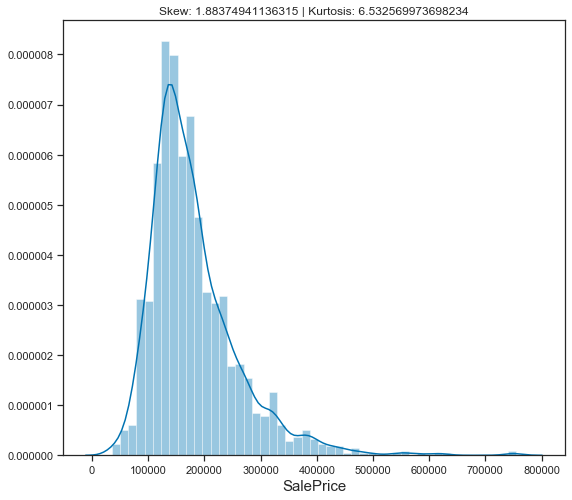

In [26]:
sns.distplot(sale_price_df['SalePrice']);
plt.title("Skew: {} | Kurtosis: {}".format(sale_price_df['SalePrice'].skew(), sale_price_df['SalePrice'].kurt()));

In [27]:
numeric_columns = data.select_dtypes('number').columns
numeric_columns = numeric_columns[~numeric_columns.str.contains('^Has')]
numeric_columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'House_Qual', 'Total_bathrooms', 'Total_basement_SF',
       'Total_sqr_footage'],
      dtype='object')

In [28]:
len(numeric_columns)

29

In [29]:
X_train = data.iloc[:len(train),:].copy()
X_test = data.iloc[len(train):,:].copy()
X_train = pd.concat([X_train,sale_price_df['SalePrice']], axis = 1)

In [30]:
X_train.dtypes

MSSubClass             object
MSZoning               object
LotFrontage           float64
LotArea                 int64
LotShape             category
LandContour          category
LotConfig              object
Neighborhood           object
HouseStyle             object
OverallQual             int64
OverallCond             int64
YearBuilt               int64
YearRemodAdd            int64
RoofStyle              object
Exterior1st            object
Exterior2nd            object
MasVnrType             object
MasVnrArea            float64
ExterQual            category
Foundation             object
BsmtQual             category
BsmtExposure         category
BsmtFinType1         category
BsmtFinSF1            float64
BsmtUnfSF             float64
TotalBsmtSF           float64
HeatingQC              object
1stFlrSF                int64
2ndFlrSF                int64
GrLivArea               int64
BsmtFullBath          float64
FullBath                int64
HalfBath                int64
BedroomAbv

### Use heatmap to check for multicorrelation

In [31]:
def generate_heatmap(df):
    # Generate a heatmap with the upper triangular matrix masked
    # Compute the correlation matrix
    corr = df.corr(method="spearman")
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    plt.figure(figsize = (15,9));
    # Draw the heatmap with the mask 
    sns.heatmap(corr, mask=mask, cmap='coolwarm', fmt = '.2f', linewidths=.5, annot = True);
    plt.title("Correlation heatmap");
    return

### Check correlation of predictor variables with target variables

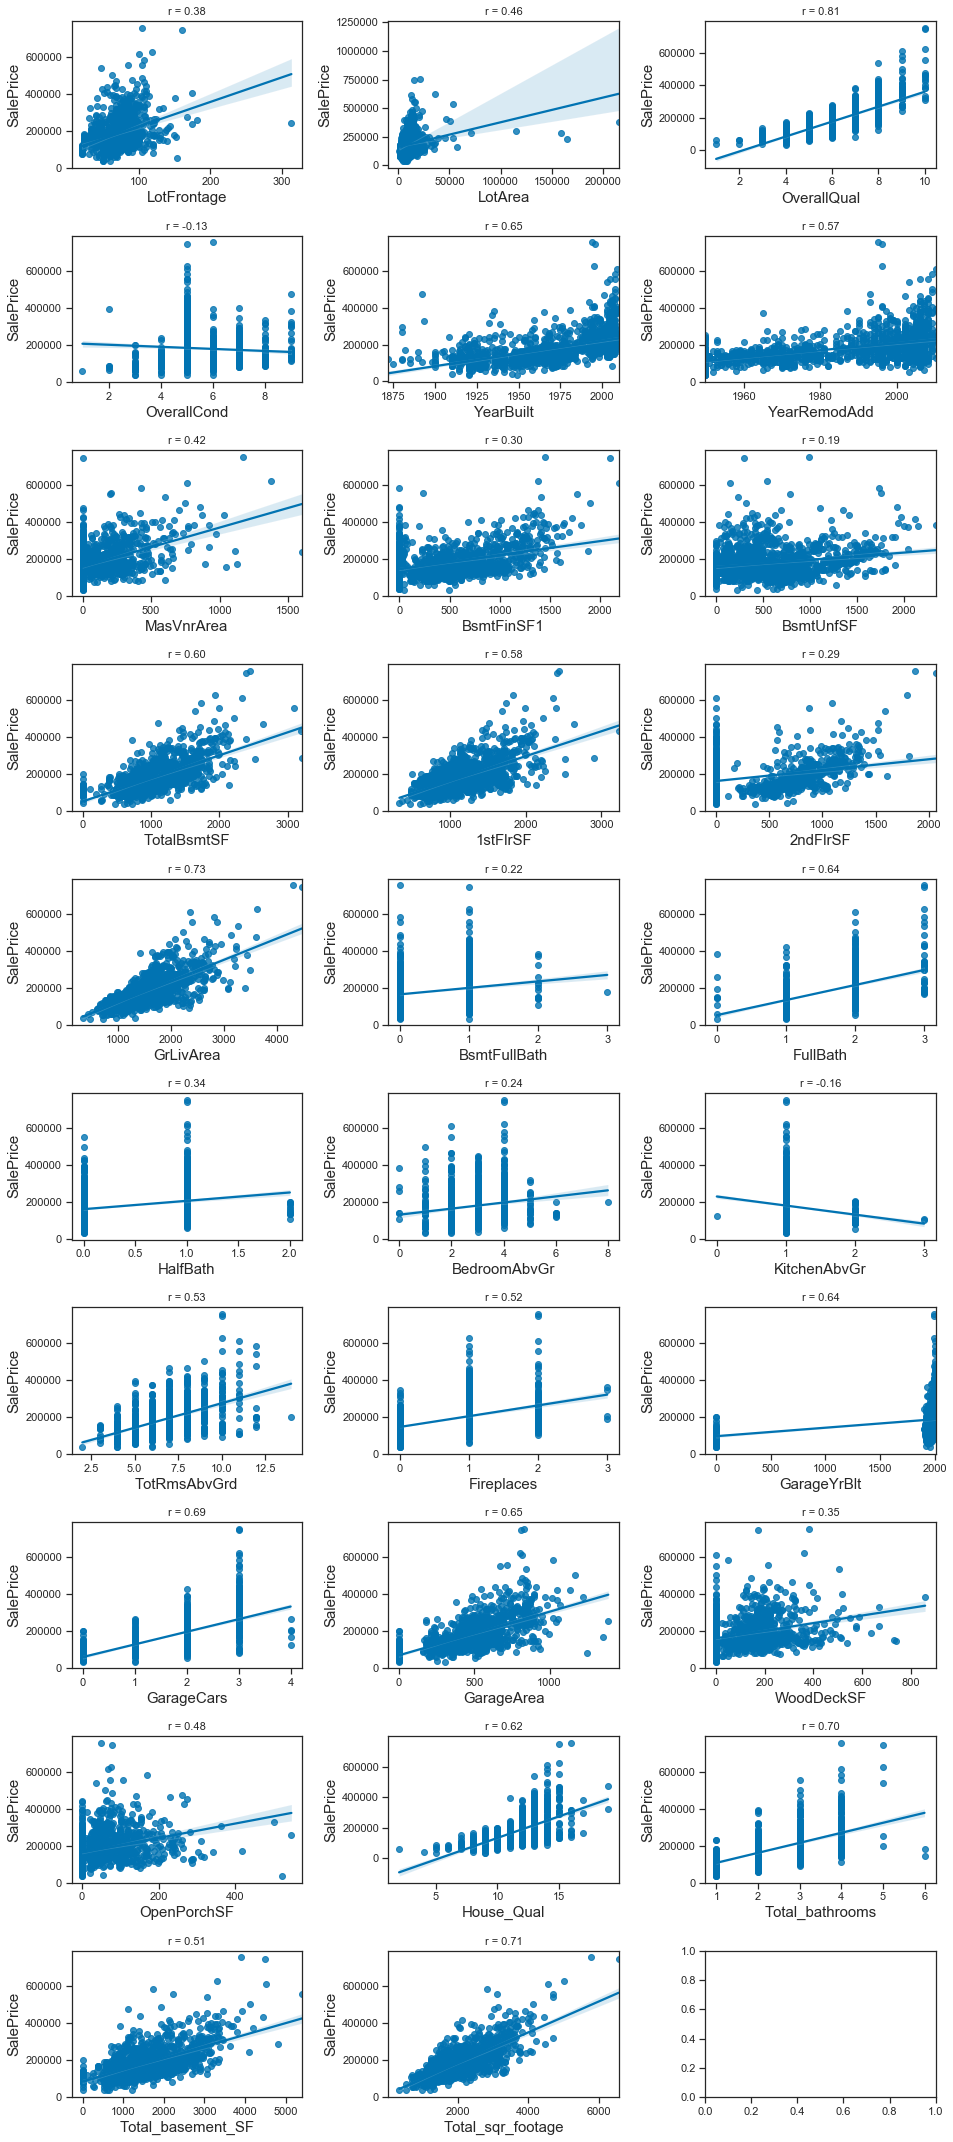

In [32]:
import math
correlation_results_list = []
ncols = 3
nrows = math.ceil(len(numeric_columns)/ncols)
fig, axes = plt.subplots(nrows,ncols, figsize=(ncols*4.5,nrows*3))
axes_list = [item for sublist in axes for item in sublist] 
for col in numeric_columns:
    ax = axes_list.pop(0) # Take the first axes of the axes_list
    sns.regplot(X_train[col], X_train['SalePrice'], ax = ax)
    stp = spearmanr(X_train[col], X_train['SalePrice'])
    str_title = "r = " + "{0:.2f}".format(stp[0])
    ax.set_title(str_title,fontsize=11)
    correlation_results_list.append((col, abs(stp[0])))
    
plt.tight_layout(); 
plt.show();

In [33]:
correlation_df = pd.DataFrame(correlation_results_list, columns = ['column_name', 'correlation'])
correlation_df.sort_values(by = 'correlation', ascending = False, inplace = True)
correlation_df.head()

,column_name,correlation
2,OverallQual,0.813513
12,GrLivArea,0.732349
28,Total_sqr_footage,0.707817
26,Total_bathrooms,0.697553
21,GarageCars,0.691027


In [34]:
columns_with_high_corr = correlation_df.loc[correlation_df['correlation']>=0.6, 'column_name'].to_list()
columns_with_high_corr

['OverallQual',
 'GrLivArea',
 'Total_sqr_footage',
 'Total_bathrooms',
 'GarageCars',
 'YearBuilt',
 'GarageArea',
 'FullBath',
 'GarageYrBlt',
 'House_Qual',
 'TotalBsmtSF']

Dropping numeric columns having low correlation

In [35]:
columns_with_low_corr = correlation_df[correlation_df['correlation']<0.6]['column_name'].to_list()

### Dropping columns having low correlation with SalePrice

In [36]:
data.drop(columns = columns_with_low_corr, inplace = True)
X_train.drop(columns = columns_with_low_corr, inplace = True)

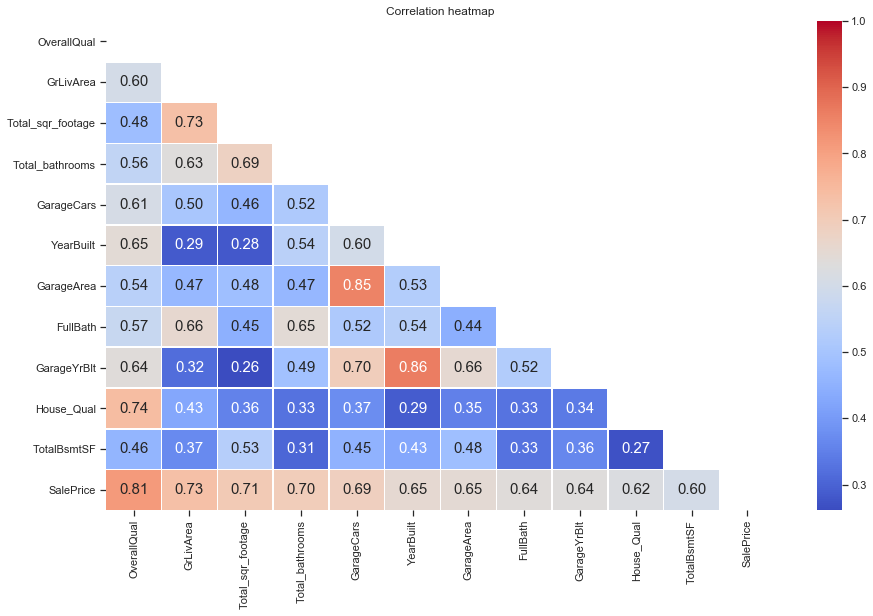

In [37]:
generate_heatmap(X_train[columns_with_high_corr+['SalePrice']])

Dropping columns to avoid multicolinearity
- OverallQual with __House_Qual__ 
- YearBuilt with __GarageYrBlt__
- GrLivArea with __Total_sqr_footage__ 
- GarageCars with __GarageArea__

- GarageCars with __GarageArea and GarageYrBlt__

### Dropping columns to avoid multicolinearity

In [38]:
data.drop(columns = ['House_Qual', 'GarageArea', 'GarageYrBlt', 'Total_sqr_footage', 'YearBuilt'], inplace = True)
X_train.drop(columns = ['House_Qual', 'GarageArea', 'GarageYrBlt', 'Total_sqr_footage', 'YearBuilt'], inplace = True)

In [39]:
data.shape

(2916, 30)

In [40]:
X_train.shape

(1457, 31)

In [41]:
category_cols = X_train.select_dtypes(['object', 'category', 'int32']).columns
category_cols

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig',
       'Neighborhood', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure',
       'BsmtFinType1', 'HeatingQC', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'MoSold', 'YrSold', 'SaleCondition', 'Has_fireplace'],
      dtype='object')

#### Applying log(1+x) transform on SalePrice

For performing anova the numerical variable must be normally distributed

In [42]:
X_train['SalePrice'] = np.log1p(X_train['SalePrice'])

### Nominal Categorical and continuous (target) variable

In [43]:
categ_columns_with_high_association = []
categ_columns_with_low_association = []
def perform_anova_and_its_results(categ_col, num_col='SalePrice', df = X_train):
    df_sst = len(df[num_col])-1
    df_ssb = df[categ_col].nunique() - 1
    df_ssw = df_sst - df_ssb
    F_critical = f.ppf(0.95, df_ssb, df_ssw)
#     print("F_Critical: {0:.3f}".format(F_critical))
    results = ols('{} ~{}'.format(num_col, categ_col), data = df).fit()
    aov_table = sm.stats.anova_lm(results, typ = 1)  
    F_stat = aov_table.loc[categ_col, 'F']
#     print("F_statistic: {0:.3f}".format(F_stat))
    if (F_stat > F_critical):
#         print("F-statistic is more than F-critical")
#         print("There is an association between {} and {}".format(categ_col,num_col))
        categ_columns_with_high_association.append(categ_col)
    else:
#         print("F-statistic is less than F-critical")
#         print("There is no association between {} and {}".format(categ_col,num_col))
        categ_columns_with_low_association.append(categ_col)
#     print('-'*30)

In [44]:
for col in category_cols:
    perform_anova_and_its_results(col)

In [45]:
categ_columns_with_low_association

['MoSold', 'YrSold']

#### Dropping columns

In [46]:
data.drop(columns = categ_columns_with_low_association, inplace = True)
X_train.drop(columns = categ_columns_with_low_association, inplace = True)

#### Association between 2 nominal binary variables
Can be used to avoid multicolinearity

In [47]:
def phi_coefficient(a,b):
    temp = pd.crosstab(a,b)
    nr = (temp.iloc[1,1] * temp.iloc[0,0]) - (temp.iloc[0,1]*temp.iloc[1,0])
    dr = np.sqrt(np.product(temp.apply(sum, axis = 'index')) * np.prod(temp.apply(sum, axis = 'columns')))
    return(nr/dr)

In [48]:
cat_binary_cols = []
for col in X_train.select_dtypes(['int32', 'object']).columns:
    if (X_train[col].nunique()==2):
        cat_binary_cols.append(col)
        
cat_binary_cols

['Has_fireplace']

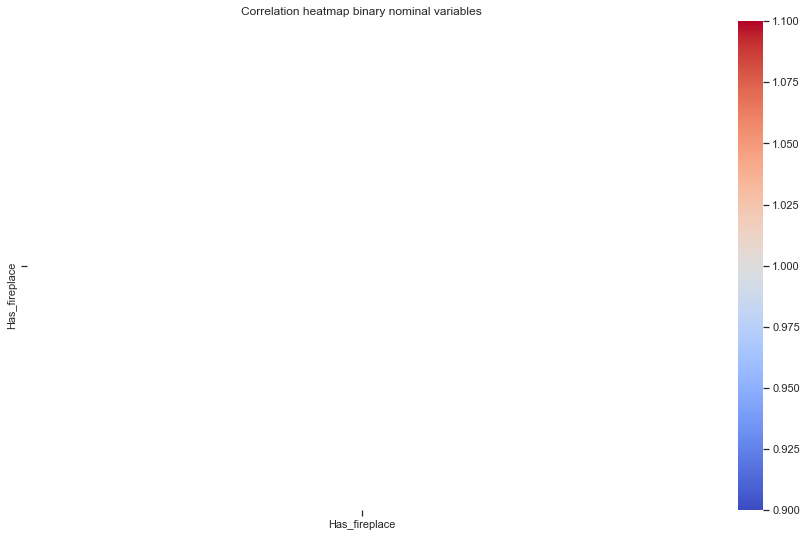

In [49]:
temp = pd.DataFrame(columns=cat_binary_cols, index=cat_binary_cols).fillna(0)
for row in cat_binary_cols:
    a = row
    for col in cat_binary_cols:
        b = col
        temp.loc[a,b] = phi_coefficient(X_train[a],X_train[b])
        temp.loc[b,a] = temp.loc[a,b]
          
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(temp, dtype=np.bool))
plt.figure(figsize = (15,9));
# Draw the heatmap with the mask 
sns.heatmap(temp, mask=mask, cmap='coolwarm', fmt = '.2f', linewidths=.5, annot = True);
plt.title("Correlation heatmap binary nominal variables");

There is no association or correlation between the nominal and binary variables.

In [50]:
del(cat_binary_cols)

#### EDA - Category and Category analysis



In [51]:
def cramers_v(a,b):
    crosstab = pd.crosstab(a,b)
    chi2 = chi2_contingency(crosstab)[0]  # chi-squared value
    n = crosstab.sum().sum()
    phi2 = chi2/n
    r, k = crosstab.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return(np.sqrt(phi2corr/min((kcorr-1),(rcorr-1))))


from collections import Counter
def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :return: float
    """
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy


def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = stats.entropy(p_x)
    if s_x == 0:
        return(1)
    else:
        return((s_x - s_xy)/s_x)

In [52]:
category_cols = X_train.select_dtypes(['object', 'category', 'int32']).columns.to_list()
category_cols

['MSSubClass',
 'MSZoning',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'HouseStyle',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'HeatingQC',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'SaleCondition',
 'Has_fireplace']

In [53]:
len(category_cols)

22

In [54]:
temp = pd.DataFrame(columns=category_cols, index=category_cols).fillna(0)
cat_col_correlation = []
for row in category_cols:
    a = row
    for col in category_cols:
        b = col
        temp.loc[a,b] = theils_u(X_train[a],X_train[b])
        temp.loc[b,a] = temp.loc[a,b]
        cat_col_correlation.append((a,b,temp.loc[a,b]))
          

In [55]:
cat_cols_corr_df = pd.DataFrame(cat_col_correlation, columns = ['col1', 'col2', 'correlation'])
cat_cols_corr_df.head()

,col1,col2,correlation
0,MSSubClass,MSSubClass,1.000000
1,MSSubClass,MSZoning,0.109543
2,MSSubClass,LotShape,0.030206
3,MSSubClass,LandContour,0.020963
4,MSSubClass,LotConfig,0.017846


In [56]:
cat_cols_corr_df.shape

(484, 3)

In [57]:
high_corr_cat=cat_cols_corr_df[(cat_cols_corr_df['correlation']>=0.6) & (cat_cols_corr_df['col1']!=cat_cols_corr_df['col2'])]
high_corr_cat.head()

,col1,col2,correlation
27,MSZoning,Neighborhood,0.672667
132,HouseStyle,MSSubClass,0.900760
185,Exterior1st,Exterior2nd,0.824017
206,Exterior2nd,Exterior1st,0.797999
479,Has_fireplace,FireplaceQu,1.000000


In [58]:
high_corr_cat

,col1,col2,correlation
27,MSZoning,Neighborhood,0.672667
132,HouseStyle,MSSubClass,0.900760
185,Exterior1st,Exterior2nd,0.824017
206,Exterior2nd,Exterior1st,0.797999
479,Has_fireplace,FireplaceQu,1.000000


Has multicolinearity

In [59]:
data.drop(columns = ['Has_fireplace', 'Exterior1st', 'MSSubClass', 'MSZoning'], inplace = True)
X_train.drop(columns = ['Has_fireplace', 'Exterior1st', 'MSSubClass', 'MSZoning'], inplace = True)

In [60]:
data.shape

(2916, 24)

In [61]:
X_train.head()

,LotShape,LandContour,LotConfig,Neighborhood,HouseStyle,OverallQual,RoofStyle,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,TotalBsmtSF,HeatingQC,GrLivArea,FullBath,FireplaceQu,GarageType,GarageFinish,GarageCars,SaleCondition,Total_bathrooms,SalePrice
0,Reg,Lvl,Inside,CollgCr,2Story,7,Gable,VinylSd,BrkFace,Gd,PConc,Gd,No,GLQ,856.0,Ex,1710,2,None,Attchd,RFn,2.0,Normal,4.0,12.247699
1,Reg,Lvl,FR2,Veenker,1Story,6,Gable,MetalSd,None,TA,CBlock,Gd,Gd,ALQ,1262.0,Ex,1262,2,TA,Attchd,RFn,2.0,Normal,2.0,12.109016
2,IR1,Lvl,Inside,CollgCr,2Story,7,Gable,VinylSd,BrkFace,Gd,PConc,Gd,Mn,GLQ,920.0,Ex,1786,2,TA,Attchd,RFn,2.0,Normal,4.0,12.317171
3,IR1,Lvl,Corner,Crawfor,2Story,7,Gable,Wd Shng,None,TA,BrkTil,TA,No,ALQ,756.0,Gd,1717,1,Gd,Detchd,Unf,3.0,Abnorml,2.0,11.849405
4,IR1,Lvl,FR2,NoRidge,2Story,8,Gable,VinylSd,BrkFace,Gd,PConc,Gd,Av,GLQ,1145.0,Ex,2198,2,TA,Attchd,RFn,3.0,Normal,4.0,12.429220


In [62]:
t = X_train.select_dtypes(['int64', 'float64']).columns.tolist()
t.remove('SalePrice')
t

['OverallQual',
 'TotalBsmtSF',
 'GrLivArea',
 'FullBath',
 'GarageCars',
 'Total_bathrooms']

Checking whether the columns are normally distributed

In [63]:
X_train.select_dtypes(['int64', 'float64']).columns

Index(['OverallQual', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'GarageCars',
       'Total_bathrooms', 'SalePrice'],
      dtype='object')

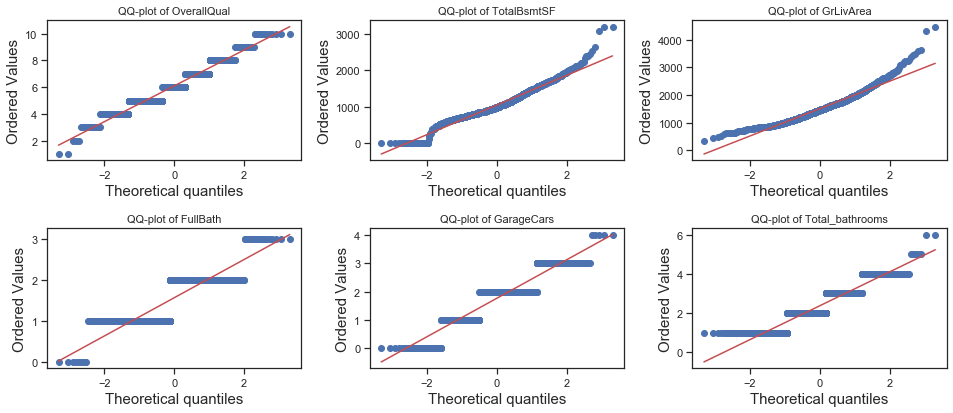

In [64]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4.5,nrows*3))
axes_list = [item for sublist in axes for item in sublist]
for col in t:
    ax = axes_list.pop(0) # Take the first axes of the axes_list
    probplot(X_train[col], dist = 'norm', plot = ax)
    str_title = "QQ-plot of {}".format(col)
    ax.set_title(str_title,fontsize=11)

    
plt.tight_layout(); 
plt.show();

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

Converting other numerical columns to normal

In [65]:
for col in t:
    X_train[col] = boxcox1p(X_train[col], boxcox_normmax(X_train[col]+1))
    data[col] = boxcox1p(data[col], boxcox_normmax(data[col]+1))

Checking the normality of the columns again

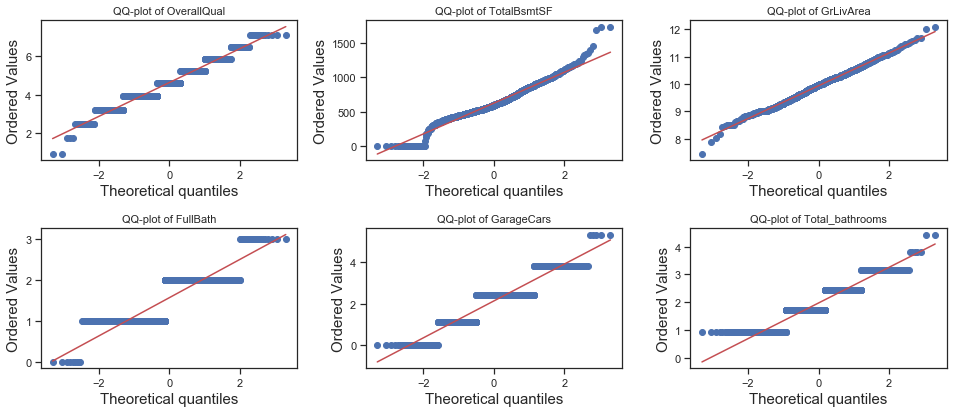

In [66]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4.5,nrows*3))
axes_list = [item for sublist in axes for item in sublist]
for col in t:
    ax = axes_list.pop(0) # Take the first axes of the axes_list
    probplot(X_train[col], dist = 'norm', plot = ax)
    str_title = "QQ-plot of {}".format(col)
    ax.set_title(str_title,fontsize=11)

    
plt.tight_layout(); 
plt.show();

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

#### Nominal columns

In [67]:
nominal_cols = X_train.select_dtypes('object').columns.to_list()
nominal_cols

['LotConfig',
 'Neighborhood',
 'HouseStyle',
 'RoofStyle',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'HeatingQC',
 'SaleCondition']

## Modelling

In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, OneHotEncoder,OrdinalEncoder, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline

In [69]:
data.shape

(2916, 24)

In [70]:
X_train.shape

(1457, 25)

In [71]:
train = data.iloc[:len(X_train),:].copy()
train['SalePrice'] = X_train['SalePrice'].copy()
test = data.iloc[len(X_train):,:].copy()

In [72]:
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

Train shape:  (1457, 25)
Test shape:  (1459, 24)


In [73]:
X = train.loc[:,train.columns!='SalePrice']
y = train['SalePrice'].copy()
X.shape

(1457, 24)

In [74]:
X.head()

,LotShape,LandContour,LotConfig,Neighborhood,HouseStyle,OverallQual,RoofStyle,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,TotalBsmtSF,HeatingQC,GrLivArea,FullBath,FireplaceQu,GarageType,GarageFinish,GarageCars,SaleCondition,Total_bathrooms
0,Reg,Lvl,Inside,CollgCr,2Story,5.391961,Gable,VinylSd,BrkFace,Gd,PConc,Gd,No,GLQ,418.285563,Ex,8.339937,1.810499,None,Attchd,RFn,2.241648,Normal,2.574343
1,Reg,Lvl,FR2,Veenker,1Story,4.715004,Gable,MetalSd,None,TA,CBlock,Gd,Gd,ALQ,587.580029,Ex,7.962252,1.810499,TA,Attchd,RFn,2.241648,Normal,1.503570
2,IR1,Lvl,Inside,CollgCr,2Story,5.391961,Gable,VinylSd,BrkFace,Gd,PConc,Gd,Mn,GLQ,445.546037,Ex,8.394286,1.810499,TA,Attchd,RFn,2.241648,Normal,2.574343
3,IR1,Lvl,Corner,Crawfor,2Story,5.391961,Gable,Wd Shng,None,TA,BrkTil,TA,No,ALQ,375.167203,Gd,8.345040,0.942176,Gd,Detchd,Unf,3.484370,Abnorml,1.503570
4,IR1,Lvl,FR2,NoRidge,2Story,6.052677,Gable,VinylSd,BrkFace,Gd,PConc,Gd,Av,GLQ,539.609942,Ex,8.654708,1.810499,TA,Attchd,RFn,3.484370,Normal,2.574343


In [75]:
train.shape

(1457, 25)

#### one hot encoder

In [76]:
ohe_dict_cols = {}
for col in X.select_dtypes(include=['object']).dtypes.index:
    ohe_dict_cols[col] = pd.Series(X[col].unique()).to_list()
    
# For one-hot encoder
t_k = []  # nominal column names
t_v = []  # values of nominal columns
for k,v in ohe_dict_cols.items():
    t_k.append(k)
    t_v.append(v)

#### Ordinal Encoder

In [77]:
ord_encod_dict = {}
for col in X.select_dtypes(include='category').columns:
    ord_encod_dict[col] = pd.Series(data[col].unique().sort_values()).to_list()

# For ordinal encoder
ordinal_cols = []
ordinal_vals = []
for k,v in ord_encod_dict.items():
    ordinal_cols.append(k)
    ordinal_vals.append(v)

In [78]:
number_cols = X.select_dtypes('number').columns.tolist()

In [79]:
number_cols

['OverallQual',
 'TotalBsmtSF',
 'GrLivArea',
 'FullBath',
 'GarageCars',
 'Total_bathrooms']

In [84]:
# Setup cross validation folds
kf = KFold(n_splits = 10, random_state=1, shuffle=True)

## Modelling

## 1. XGBoost model

In [85]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=1, n_jobs = -1, max_depth = 3, min_child_weight = 5,
                       alpha = 1e-5, gamma = 0, subsample=0.8, colsample_bytree=0.7, learning_rate =0.1, n_estimators = 400)

colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')


xg_pipeline = Pipeline(steps = [('colt', colT), ("xg", xg_reg)])
xg_pipeline.fit(X, y)

# prediction_XG_1 = xg_pipeline.predict(test)

scores = -cross_val_score(xg_pipeline, X, y, cv = kf, n_jobs = -1,scoring = 'neg_root_mean_squared_error')
print('RMSE scores: ', scores)
print('RMSE scores mean: {:.3f}'.format(scores.mean()))
print('RMSE scores std deviation: {:.3f}'.format(scores.std()))

RMSE scores:  [0.15565046 0.12282705 0.12624807 0.12797629 0.12741919 0.13270044
 0.1102248  0.10899652 0.11181582 0.16098224]
RMSE scores mean: 0.128
RMSE scores std deviation: 0.017


## 2. Random Forest Regressor 

In [86]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor(random_state=1, n_jobs = -1, max_depth =  8, max_samples = None, min_samples_leaf =  2, 
                              n_estimators = 120)

colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')

rf_pipeline = Pipeline(steps = [('colt', colT), ("rf", rfreg)])
rf_pipeline.fit(X, y)

scores = -cross_val_score(rf_pipeline, X, y, cv = kf, n_jobs = -1,scoring = 'neg_root_mean_squared_error')
print('RMSE scores: ', scores)
print('RMSE scores mean: {:.3f}'.format(scores.mean()))
print('RMSE scores std deviation: {:.3f}'.format(scores.std()))

RMSE scores:  [0.18814384 0.13131505 0.12094058 0.15124211 0.14414294 0.13725935
 0.12394148 0.14902085 0.1253896  0.17305116]
RMSE scores mean: 0.144
RMSE scores std deviation: 0.021


### 3. Ridge regression

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline

In [87]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(random_state = 1, alpha = 25)

rb_scaler = RobustScaler(with_centering=False)

colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')

# skb = SelectKBest(f_regression)

ridge_pipeline = Pipeline(steps = [('colt', colT), ('rb', rb_scaler), ("ridge", ridge_reg)])
ridge_pipeline.fit(X, y)

scores = -cross_val_score(ridge_pipeline, X, y, cv = kf, n_jobs = -1,scoring = 'neg_root_mean_squared_error')
print('RMSE scores: ', scores)
print('RMSE scores mean: {:.3f}'.format(scores.mean()))
print('RMSE scores std deviation: {:.3f}'.format(scores.std()))

RMSE scores:  [0.16158279 0.13515808 0.13095431 0.13589807 0.12663786 0.13418997
 0.12063112 0.1184734  0.11426463 0.16299466]
RMSE scores mean: 0.134
RMSE scores std deviation: 0.016


### 4. Lasso Regression

In [88]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(random_state = 1, alpha = 0.0005)

rb_scaler = RobustScaler(with_centering=False)

colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')

# Bigger the alpha values the lesser the features that will be selected

lasso_pipeline = Pipeline(steps = [('colt', colT),  ('rb', rb_scaler), ("lasso", lasso_reg)])
lasso_pipeline.fit(X, y)

scores = -cross_val_score(lasso_pipeline, X, y, cv = kf, n_jobs = -1,scoring = 'neg_root_mean_squared_error')
print('RMSE scores: ', scores)
print('RMSE scores mean: {:.3f}'.format(scores.mean()))
print('RMSE scores std deviation: {:.3f}'.format(scores.std()))

RMSE scores:  [0.1573913  0.13382738 0.13173866 0.13306604 0.12509218 0.13447541
 0.11801163 0.11978313 0.11657372 0.1615307 ]
RMSE scores mean: 0.133
RMSE scores std deviation: 0.015


### 5. Elastic net regression

In [89]:
from sklearn.linear_model import ElasticNet
elastic_reg = ElasticNet(random_state = 1, l1_ratio = 0.095, alpha = 0.0005)

rb_scaler = RobustScaler(with_centering=False)

colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')

# skb = SelectKBest(f_regression)

# Bigger the alpha values the lesser the features that will be selected

elastic_pipeline = Pipeline(steps = [('colt', colT),  ('rb', rb_scaler), ("elastic", elastic_reg)])
elastic_pipeline.fit(X, y)

scores = -cross_val_score(elastic_pipeline, X, y, cv = kf, n_jobs = -1,scoring = 'neg_root_mean_squared_error')
print('RMSE scores: ', scores)
print('RMSE scores mean: {:.3f}'.format(scores.mean()))
print('RMSE scores std deviation: {:.3f}'.format(scores.std()))

RMSE scores:  [0.15673023 0.13723025 0.13602451 0.1334602  0.12500561 0.13683079
 0.11768798 0.12052369 0.11563363 0.16201965]
RMSE scores mean: 0.134
RMSE scores std deviation: 0.015


In [90]:
elastic_pipeline['elastic']

ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.095,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=1, selection='cyclic', tol=0.0001, warm_start=False)

### 7. Catboost

In [91]:
from catboost import CatBoostRegressor
cat_obj_cols = X.select_dtypes(['category', 'object']).columns.to_list()

In [92]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.7, random_state=1)

cat = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, eval_metric = 'RMSE', loss_function='RMSE',
                       l2_leaf_reg = 1)

In [93]:
cat.fit(X_train, y_train, cat_features = cat_obj_cols, eval_set= (X_validation, y_validation), plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3651588	test: 0.3928122	best: 0.3928122 (0)	total: 875ms	remaining: 1m 26s
1:	learn: 0.3430065	test: 0.3705685	best: 0.3705685 (1)	total: 927ms	remaining: 45.4s
2:	learn: 0.3208177	test: 0.3480136	best: 0.3480136 (2)	total: 957ms	remaining: 30.9s
3:	learn: 0.3013621	test: 0.3285277	best: 0.3285277 (3)	total: 987ms	remaining: 23.7s
4:	learn: 0.2856938	test: 0.3120526	best: 0.3120526 (4)	total: 1.03s	remaining: 19.7s
5:	learn: 0.2696720	test: 0.2959060	best: 0.2959060 (5)	total: 1.08s	remaining: 17s
6:	learn: 0.2543644	test: 0.2801894	best: 0.2801894 (6)	total: 1.12s	remaining: 14.9s
7:	learn: 0.2418278	test: 0.2664630	best: 0.2664630 (7)	total: 1.15s	remaining: 13.2s
8:	learn: 0.2306831	test: 0.2559165	best: 0.2559165 (8)	total: 1.19s	remaining: 12s
9:	learn: 0.2205211	test: 0.2462464	best: 0.2462464 (9)	total: 1.22s	remaining: 10.9s
10:	learn: 0.2115710	test: 0.2376960	best: 0.2376960 (10)	total: 1.26s	remaining: 10.2s
11:	learn: 0.2051366	test: 0.2308329	best: 0.2308329 (1

97:	learn: 0.1025232	test: 0.1420568	best: 0.1420568 (97)	total: 3.16s	remaining: 64.4ms
98:	learn: 0.1024210	test: 0.1420239	best: 0.1420239 (98)	total: 3.17s	remaining: 32ms
99:	learn: 0.1020485	test: 0.1420182	best: 0.1420182 (99)	total: 3.18s	remaining: 0us

bestTest = 0.1420182412
bestIteration = 99



## 8. light GBM

In [94]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [95]:
lgbm = LGBMRegressor(boosting_type = 'gbdt' ,random_state=1, n_jobs=-1, learning_rate = 0.1, max_depth = 3, 
                     min_child_weight = 0.001, min_split_gain = 0, n_estimators = 250, reg_alpha = 0.01)


colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')


lgbm_pipeline = Pipeline(steps = [('colt', colT), ("lgbm", lgbm)])
lgbm_pipeline.fit(X, y)

scores = -cross_val_score(lgbm_pipeline, X, y, cv = kf, n_jobs = -1,scoring = 'neg_root_mean_squared_error')
print('RMSE scores: ', scores)
print('RMSE scores mean: {:.3f}'.format(scores.mean()))
print('RMSE scores std deviation: {:.3f}'.format(scores.std()))

RMSE scores:  [0.16253236 0.13025867 0.12375258 0.13564108 0.13589237 0.13309846
 0.11960014 0.12017116 0.12140274 0.16285517]
RMSE scores mean: 0.135
RMSE scores std deviation: 0.015


In [96]:
lgbm_pipeline['lgbm']

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0,
              n_estimators=250, n_jobs=-1, num_leaves=31, objective=None,
              random_state=1, reg_alpha=0.01, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## 9. StackingCV Regressor

In [97]:
from mlxtend.regressor import StackingCVRegressor

In [98]:
# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(lasso_pipeline['lasso'], ridge_pipeline['ridge'], xg_pipeline['xg'],
                                            lgbm_pipeline['lgbm'], elastic_pipeline['elastic']),
                                meta_regressor = xg_pipeline['xg'], use_features_in_secondary=True)


colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')


stack_gen_pipeline = Pipeline(steps = [('colt', colT), ("stack_gen", stack_gen)])
stack_gen_pipeline.fit(X, y)

scores = -cross_val_score(stack_gen_pipeline, X, y, cv = kf, n_jobs = -1,scoring = 'neg_root_mean_squared_error')
print('RMSE scores: ', scores)
print('RMSE scores mean: {:.3f}'.format(scores.mean()))
print('RMSE scores std deviation: {:.3f}'.format(scores.std()))

RMSE scores:  [0.14883843 0.1153298  0.14051258 0.13037428 0.13243394 0.13813638
 0.12516055 0.12484284 0.11065975 0.16628582]
RMSE scores mean: 0.133
RMSE scores std deviation: 0.015


## 10. Blend models and get predictions


In [99]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.05 * lasso_pipeline.predict(X)) + \
            (0.05 * ridge_pipeline.predict(X)) + \
            (0.5 * xg_pipeline.predict(X)) + \
            (0.1 * lgbm_pipeline.predict(X)) + (0.3 * stack_gen_pipeline.predict(X)))

In [100]:
# Define error metrics
from sklearn.metrics import mean_squared_error
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [101]:
# Get final precitions from the blended model
blended_score = rmsle(y, blended_predictions(X))
print('RMSE blended : {:.3f}'.format(blended_score))

RMSE blended : 0.083


In [105]:
predictions_blended = blended_predictions(test)

### Submission

In [106]:
test = pd.read_csv('test.csv')

To get our original SalePrice values back, we will apply `np.expm1` at the end of the study to cancel the `log1p` transformation after training and testing the models.

In [107]:
sub_pred = np.expm1(predictions_blended)

In [108]:
df_output = pd.DataFrame()
df_output['Id'] = test['Id']
df_output['SalePrice'] = sub_pred
df_output.head()

,Id,SalePrice
0,1461,115458.204630
1,1462,152393.850757
2,1463,174114.701600
3,1464,183656.166387
4,1465,191109.268552


In [109]:
df_output.to_csv('submission_8.csv', index = False)

In [ ]:
# progress = pd.DataFrame()
# progress['date'] = pd.to_datetime(['2020-05-13', '2020-05-25', '2020-05-31', '2020-06-06', '2020-06-12', '2020-06-15'])
# progress['rmse'] = [0.1501, 0.1541, 0.1365, 0.1358,0.134, 0.082]
# progress

In [ ]:
# sns.lineplot(data = progress, x = 'date', y = 'rmse');
# plt.title('Variation in RMSE of models created');
# plt.xticks(rotation=90);